In [488]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import pi
df = pd.read_csv('Student Feedback Surveys-Superview.csv')

In [472]:
df.head()

,ID,Location,Track,Week,Rating (Num),Schedule Pacing
0,134,San Francisco,"Apps, Explorer",Week 1,3,Just right
1,36,Los Angeles,Apps,Week 1,4,A little too fast
2,117,San Francisco,Games,Week 1,4,Way too slow
3,253,NaN,NaN,Week 2,4,A little too fast
4,350,New York City,"Apps, Explorer",Week 1,4,Just right


In [473]:
df.nunique()

ID                 1453
Location             12
Track                 5
Week                  8
Rating (Num)         12
Schedule Pacing       5
dtype: int64

In [474]:
def populate_sentiment_dict (ratings):
    sentiment_dict={'Detractor':0, 'Passive':0, 'Promoter':0, 'Other':0}
    for rating in ratings:
        if rating == np.nan or rating == '#ERROR!':
            sentiment_dict['Other'] +=1
            continue
        rating = int(rating)
        if rating >= 1 and rating <= 6:
            sentiment_dict['Detractor'] += 1
        elif rating >= 7 and rating <= 8:
            sentiment_dict['Passive'] += 1
        elif rating >= 9 and rating <= 10:
            sentiment_dict['Promoter'] += 1
        else:
            sentiment_dict['Other'] +=1
    return sentiment_dict

In [475]:
sentiment_dict = populate_sentiment_dict(df["Rating (Num)"])
sentiment_dict

{'Detractor': 119, 'Passive': 569, 'Promoter': 760, 'Other': 5}

In [476]:
track_data = np.array(df.Track)
track_dict = dict(pd.Series(track_data).value_counts())
track_dict

{'Apps': 871,
 'Apps, Explorer': 224,
 'Games': 208,
 'VR': 60,
 'Games, Explorer': 43}

In [477]:
df.Track.describe()

count     1406
unique       5
top       Apps
freq       871
Name: Track, dtype: object

In [478]:
def calc_NPS (dictionary):
    return (dictionary['Promoter'] - dictionary['Detractor']) / (dictionary['Detractor'] + dictionary['Passive'] + dictionary['Promoter'])*100

In [479]:
#Create dicitonary of sentiment based on individual tracks
A_track = populate_sentiment_dict( df[ (df.Track == 'Apps') ]['Rating (Num)'] )
AE_track = populate_sentiment_dict( df[ (df.Track == 'Apps, Explorer') ]['Rating (Num)'] )
G_track = populate_sentiment_dict( df[ (df.Track == 'Games') ]['Rating (Num)'] )
VR_track = populate_sentiment_dict( df[ (df.Track == 'VR') ]['Rating (Num)'] )
GE_track = populate_sentiment_dict( df[ (df.Track == 'Games, Explorer') ]['Rating (Num)'] )

In [507]:
#list of NPS values based on track
track_nps = np.array([calc_NPS(A_track), calc_NPS(AE_track), calc_NPS(G_track), calc_NPS(VR_track), calc_NPS(GE_track)])

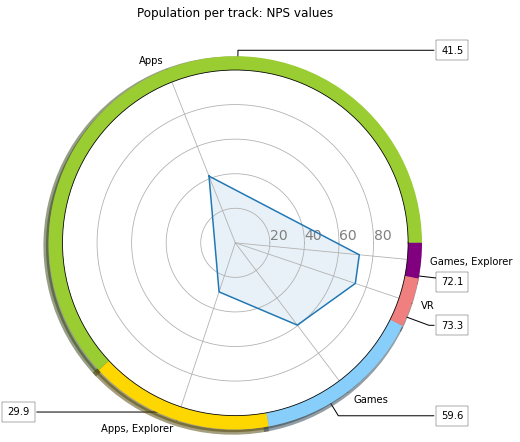

Average NPS: 55.28934167276187  [NOT A REAL NUMBER] 
  Total NPS: 44.267955801104975


In [573]:
# Set data variables
dfv = pd.DataFrame({
'group': ['NPS of tracks'],
'Apps': track_nps[0],
'Apps, Explorer': track_nps[1],
'Games': track_nps[2],
'VR': track_nps[3],
'Games, Explorer': track_nps[4]
})
categories=list(dfv)[1:]
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=dfv.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
values

#calculate the middle point of each of the pie parts 
total = sum(track_dict.values())
angles = []
offset = 0
for value in track_dict.values():
    angle = (value / total)*6.2831853071796
    offset += angle/2  #get the middle
    angles.append(offset)
    offset += angle/2  #return the remainder to the offset
angles += angles[:1]  #close the loop

#----------------------------SPIDER GRAPH BASE
# Initialise the spider plot at a point inside the pie
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), subplot_kw=dict(polar=True, zorder=1))
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

#----------------------------SPIDER GRAPH DRAWS
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], color='black', size=0)
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([20,40,60,80], ["20", "40", "60", "80"], color="grey", size=14)
#plt.yticks([25,50,75], ["25","50","75"], color="black", size=14)
plt.ylim(0,100)
# Plot data
ax.plot(angles, values, linewidth=1.5, linestyle='solid')
# Fill area
ax.fill(angles, values, 'p', alpha=0.1)

#----------------------------PIE CHART VARS
sizes = track_dict.values()
labels = track_dict.keys()
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'purple']
explode = (0, 0, 0, 0, 0)

#----------------------------PIE CHART
ax2 = fig.add_subplot(111, label="pie axes", zorder=0)
wedges, d = ax2.pie(sizes, explode=explode, labels=labels, colors=colors, shadow=True, wedgeprops = {'linewidth': 5},
            radius=1.35, startangle=0, labeldistance=1.05)

#----------------------------ANNOTATE
recipe = np.round_(track_nps,1)
bbox_props = dict(boxstyle="square,pad=0.5", fc="w", ec="k", lw=0.32)
kw2 = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):  #using pie wedges to math our points
    ang = (p.theta2 - p.theta1)/2.5 + p.theta1  #change /2 to shift left/right
    y = np.sin(np.deg2rad(ang-5))  #offcenter the angle of lines futher
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {1: "right", -1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw2["arrowprops"].update({"connectionstyle": connectionstyle})
    ax2.annotate(recipe[i], xy=(x, y), xytext=(1.65*np.sign(x), 1.4*y), horizontalalignment=horizontalalignment, **kw2)
    
#-----------------------------DRAW
ax.set_title("Population per track: NPS values\n\n")
ax2.set(aspect="equal")

plt.show()

#-----------------------------Print NPS
print (f'Average NPS: {track_nps.mean()}  [NOT A REAL NUMBER] ')
print (f'  Total NPS: {calc_NPS(sentiment_dict)}')

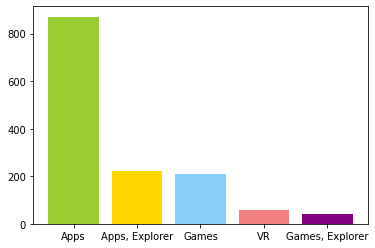

In [621]:
height = track_dict.values()
bars = track_dict.keys()
y_pos = np.arange(len(bars))

plt.bar(y_pos, height, color = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'purple'])
plt.xticks(y_pos, bars)
plt.show()

In [641]:
rating=[]
textval = {"0":0, "1":1, "2":2, "3":3, "4":4, "5":5, "6":6, "7":7, "8":8, "9":9, "10":10}
for rate in df['Rating (Num)']:
    val = 0
    if rate in textval:
        val = textval[rate]
    rating.append(val)
df['Rating'] = rating

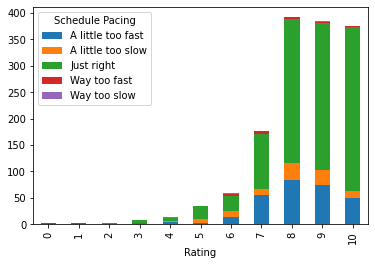

In [642]:
df.groupby(['Rating'])['Schedule Pacing'].value_counts().unstack().plot(kind='bar',stacked=True)

In [627]:
weeksEnrolled=[]
textval = {"Week 0":0, "Week 1":1, "Week 2":2, "Week 3":3, "Week 4":4, "Week 5":5, "Week 6":6, "Week 7":7, "Week 8":8}
for week in df['Week']:
    val = 0
    if week in textval:
        val = textval[week]
    weeksEnrolled.append(val) 
df['Weeks Enrolled'] = weeksEnrolled

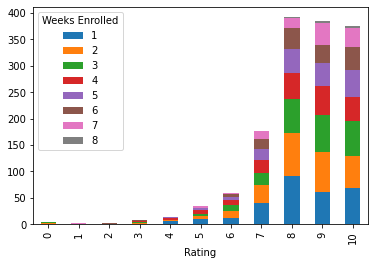

In [629]:
df.groupby(['Rating'])['Weeks Enrolled'].value_counts().unstack().plot(kind='bar',stacked=True)

In [643]:
pacing=[]
for pace in df['Schedule Pacing']:
    val = 0
    if pace == "Way too fast":
        val = 1
    elif pace == "A little too fast":
        val = 2
    elif pace == "Just right": 
        val = 3
    elif pace == "A little too slow":
        val = 4
    elif pace == "Way too slow":
        val = 5
    pacing.append(val)
df['Pacing'] = pacing

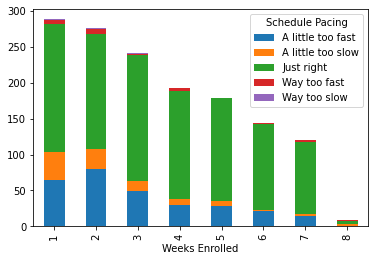

In [647]:
df.groupby(['Weeks Enrolled'])['Schedule Pacing'].value_counts().unstack().plot(kind='bar',stacked=True)